In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive
! ls /content/drive

/content/drive
MyDrive


In [2]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,Flatten
from tensorflow.keras.layers import Conv2D,Activation,MaxPooling2D,AveragePooling2D,Input
from tensorflow.keras.optimizers import SGD,Adam,RMSprop
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.regularizers import l2

from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar100
from sklearn.model_selection import train_test_split
#from kerastuner import RandomSearch
#from kerastuner import HyperModel
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#load data
(X_train,y_train),(X_test,y_test)=cifar100.load_data()

In [4]:
from scipy import ndimage
X_train=ndimage.zoom(X_train,(1,3,3,1),order=0)
X_test=ndimage.zoom(X_test,(1,3,3,1),order=0)

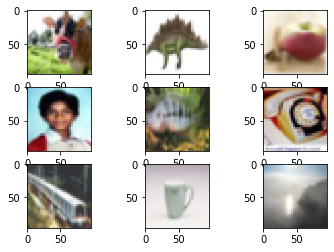

In [5]:
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(X_train[i])
# show the figure
plt.show()

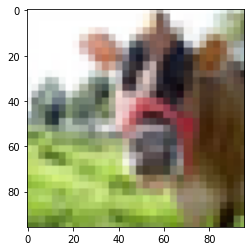

In [ ]:
plt.imshow(X_train[0])

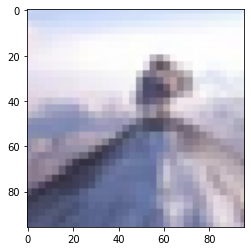

In [ ]:
plt.imshow(X_test[0])

In [6]:
# Chia training set, validation set theo ty le 80-20
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.2,random_state=42)
print("Traning set: ",X_train.shape[0])
print("Validation set: ",X_val.shape[0])
print("Test set: ",X_test.shape[0])

Traning set:  40000
Validation set:  10000
Test set:  10000


In [7]:
X_t=X_train[:200]
y_t=y_train[:200]
print(X_t.shape)

(200, 96, 96, 3)


In [8]:
#augmentation data
aug_train=ImageDataGenerator(rescale=1./255,rotation_range=30, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2,zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
aug_val=ImageDataGenerator(rescale=1./255)

In [10]:
base_model=ResNet152V2(include_top=False,weights='imagenet',input_tensor=Input(shape=(96,96,3)))
fc_head=base_model.output
fc_head=AveragePooling2D(pool_size=(2,2))(fc_head)
fc_head=Flatten()(fc_head)

fc_head=Dense(512,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(fc_head)
fc_head=Dropout(rate=0.5)(fc_head)
fc_head=Dense(256,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(fc_head)
fc_head=Dropout(rate=0.4)(fc_head)
fc_head=Dense(100,activation='softmax',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(fc_head)

model=Model(inputs=base_model.input,outputs=fc_head)

In [10]:
base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 48, 48, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 50, 50, 64)   0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 48, 48, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 50, 50, 64)   0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [12]:
train_generator = aug_train.flow(X_train,y_train,batch_size=128)
valid_generator = aug_val.flow(X_val,y_val,batch_size=128)

In [13]:
for layer in base_model.layers:
    layer.trainable=False
opt=Adam(0.001)
model.compile(opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
num_epochs=15
H=model.fit(train_generator,steps_per_epoch=len(X_train)//128,validation_data=valid_generator,validation_steps=len(X_val)//128,epochs=num_epochs,verbose=1)

Epoch 1/15
312/312 [==============================] - 3686s 12s/step - loss: 8.6455 - accuracy: 0.0139 - val_loss: 4.3589 - val_accuracy: 0.0225
Epoch 2/15
204/312 [==================>...........] - ETA: 16:56 - loss: 4.3785 - accuracy: 0.0119

KeyboardInterrupt: ignored

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


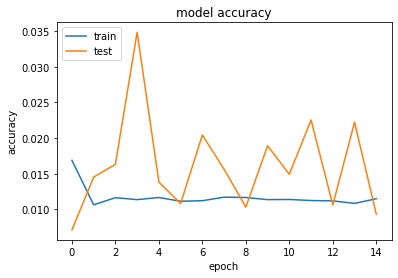

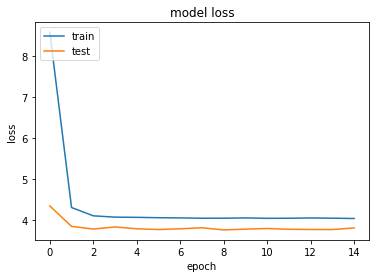

In [ ]:
print(H.history.keys())
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(X_test, y_test)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

313/313 [==============================] - 25s 71ms/step - loss: 853.4803 - accuracy: 0.0000e+00
Test loss: 853.4803
Test accuracy: 0.0000
